<p>
  <img src="https://raw.githubusercontent.com/lorenzonava96/TerraTrack/main/figures/TerraTrack.png" alt="TerraTrack" width="120">
</p>

# TerraTrack — Feature Tracking Workflow

This notebook implements the **feature tracking component** of TerraTrack for detecting and monitoring slow-moving landslides using **Sentinel-2 imagery**.


<table class="tfo-notebook-buttons" align="left">
  <tr>
    <td>
      <a target="_blank" href="https://github.com/lorenzonava96/TerraTrack/tree/main">
        <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
        View repository on GitHub
      </a>
    </td>
    <td>
      <img src="https://www.tensorflow.org/images/download_logo_32px.png" />
      <em>Download notebook (coming soon)</em>
    </td>
    <td>
      <img src="https://www.tensorflow.org/images/download_logo_32px.png" />
      <em>Paper (coming soon)</em>
    </td>
  </tr>
</table>


In [ ]:
!git clone https://github.com/lorenzonava96/TerraTrack.git
!pip uninstall earthengine-api -y
!pip uninstall geemap -y
!pip install -r TerraTrack/requirements.txt
!pip install --upgrade earthengine-api geemap

Cloning into 'TerraTrack'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 216 (delta 38), reused 6 (delta 6), pack-reused 152 (from 1)
Receiving objects: 100% (216/216), 2.56 MiB | 13.06 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Found existing installation: earthengine-api 1.5.8
Uninstalling earthengine-api-1.5.8:
  Successfully uninstalled earthengine-api-1.5.8
Found existing installation: geemap 0.35.3
Uninstalling geemap-0.35.3:
  Successfully uninstalled geemap-0.35.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.7/459.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00


In [2]:
import rasterio
import os
import glob
import numpy as np
from skimage import exposure
from datetime import datetime
from scipy.ndimage import convolve
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
import ee
import geemap
from TerraTrack.src import *

output_dir = 'outputs'

ee.Authenticate(auth_mode='notebook')


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=MHiMYVBUjkO_UxEgZu8BqedV2DMSlidAa5c8C2yHC3w&tc=hqDCuGfXZM8IJf7dZ-RqEQR8tjDy5g8XAFTvrCXF3UY&cc=m40XbRgHOJ3r0jfPvhO6O4I02ESXBVIJ5m1287r6TQI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AQSTgQF6CbvwxJse68J_RyoUclOpqzQ2yj11wWAwGWLUHa391VcLA9oJWFs

Successfully saved authorization token.


## Initialize and Define Area of Interest (AoI)

This section initializes a `Map` instance using the `geemap` library and centers it on a global view with a satellite basemap. The map will help define the Area of Interest (AOI).

### Instructions:
1. Use the map tools on the left to draw a single rectangular box defining your AOI.
2. Use the globe icon on the top left to search for specific locations if needed.


In [3]:
# Create a Map instance
Map = geemap.Map()

# Add a satellite basemap for visualization (similar to Google Earth)
Map.add_basemap('HYBRID')

# Center the map globally
Map.setCenter(0, 0, 2)  # Center on the world with zoom level 2

# Display the map for user interaction
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### **Filtering and Processing Sentinel-2 Imagery**

This block sets parameters to filter and process Sentinel-2 images.

#### 🔍 Filters:
- **Date range**: `START_YEAR`–`END_YEAR` (default: 2015–2025)
- **Season**: January 1 – December 30
- **Cloud cover**: Max per tile via `CLOUD_COVER_MAX` (default: 50%)
- **Cloud removal in ROI**: Enabled via `check_clouds`, excludes images with >5% clouds (`cloud_threshold`)
- **Snow removal**: Enabled via `check_snow`, excludes images with >5% snow (`snow_threshold`)
- **Final cutoff date**: Optional (`final_date`) for limiting analysis window

#### 💧 Sampling & Water Masking:
- **Images per year**: `N_PER_YEAR` (default: 5)
- **Water masking**: Enabled via `mask_water`, uses NDWI

#### 📤 Outputs:
- `final_collection`: Filtered Sentinel-2 image collection
- `morpho`: Terrain data (DEM, slope, aspect)

💡 **Tips**:
- Tweak `cloud/snow thresholds` to trade off quality vs. coverage
- Use `final_date` for back-analysis or scenario-based studies
- Increase `N_PER_YEAR` for higher temporal resolution
- Use `check_snow` in snowy terrain to reduce noise

➡️ The block prints the number of selected images and acquisition dates.

In [4]:
# Define filtering parameters
SUMMER_START = '-01-01'       # Start of seasonal filter (MM-DD)
SUMMER_END = '-12-30'         # End of seasonal filter (MM-DD)
START_YEAR = 2015             # First year to include
END_YEAR = 2025               # Last year to include
final_date = None     # Optional: limit images up to this date (YYYY-MM-DD)

# Image and mask filtering
CLOUD_COVER_MAX = 50          # Max allowable cloud cover per tile (%)
N_PER_YEAR = 5               # Max number of images sampled per year
mask_water = False            # Enable NDWI-based water masking
check_clouds = True           # Remove images with too much cloud in the ROI
cloud_threshold = 5           # Max allowable cloud cover in ROI (%)
check_snow = True            # Remove images with excessive snow in ROI
snow_threshold = 5            # Max allowable snow cover in ROI (%)

# Define region of interest from drawn features
roi = ee.FeatureCollection(Map.draw_features).geometry()

# Process Sentinel-2 imagery and extract terrain data
final_collection, morpho = process_sentinel2_data(
    roi, START_YEAR, END_YEAR, SUMMER_START, SUMMER_END,
    cloud_cover_max=CLOUD_COVER_MAX,
    n_per_year=N_PER_YEAR,
    mask_water=mask_water,
    check_clouds=check_clouds,
    cloud_threshold=cloud_threshold,
    check_snow=check_snow,
    snow_threshold=snow_threshold,
    final_date=final_date
)

# Print the size of the filtered image collection
print("Final collection size:", final_collection.size().getInfo())

# Print acquisition dates of selected images
dates = final_collection.aggregate_array('system:time_start') \
    .map(lambda d: ee.Date(d).format('YYYY-MM-dd')).getInfo()

print("Acquisition dates in final_collection:")
for d in dates:
    print(d)

print("Processing completed. Final collection and morpho are ready to be downloaded.")


Number of images after date and tile-wide cloud filtering: 700
Number of images fully covering the ROI: 356
Number of images after ROI-based cloud filtering: 242
Number of images after ROI-based snow filtering: 231
Adjusting START_YEAR to first available data year: 2015
Year 2015: 13 images available
Year 2016: 18 images available
Year 2017: 16 images available
Year 2018: 17 images available
Year 2019: 22 images available
Year 2020: 26 images available
Year 2021: 14 images available
Year 2022: 47 images available
Year 2023: 32 images available
Year 2024: 21 images available
Year 2025: 4 images available
Number of images after removing duplicate tiles: 53
Final collection size: 53
Acquisition dates in final_collection:
2015-07-04
2015-08-03
2015-08-13
2015-09-12
2016-01-20
2016-07-18
2016-08-07
2016-09-26
2016-10-16
2017-01-24
2017-06-13
2017-07-18
2017-08-17
2017-10-06
2018-01-24
2018-04-19
2018-07-23
2018-08-27
2018-09-26
2019-01-14
2019-03-15
2019-06-28
2019-09-16
2019-10-26
2020-01-

### **Downloading Processed Data**

This block automates export of Sentinel-2 and terrain products:

- **Sentinel-2 Composite**:  
  - Creates a stack of the **B8 (NIR) band**  
  - Output: `S2_Composite.tif`

- **Morphological Data**:  
  - Includes **DEM, Slope, and Aspect**  
  - Output: `morpho.tif`

- **Metadata**:  
  - Includes image IDs, dates, cloud cover, orbit info, and tile IDs  
  - Output: `S2_Metadata.csv`

💡 No user input needed — the download is fully automated.

In [5]:
import pandas as pd

# Set up directory for output files
os.makedirs(output_dir, exist_ok=True)

# Generate a composite image by stacking the B8 band across the image collection
composite_image = final_collection.select('B8').toBands()
composite_output_path = os.path.join(output_dir, 'S2_Composite.tif')

# Download S2 Composite
geemap.download_ee_image(composite_image, composite_output_path, scale=None, crs=None, region=roi.getInfo())
print("Composite image downloaded.")

# Download morpho
composite_output_path = os.path.join(output_dir, 'morpho.tif')
geemap.download_ee_image(morpho, composite_output_path, scale=None, crs=None, region=roi.getInfo())

print("DEM, Slope, and Aspect downloaded.")

# Aggregate metadata arrays for the entire collection in a single query
image_ids = final_collection.aggregate_array('system:index').getInfo()
dates = final_collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()
cloud_covers = final_collection.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
orbits = final_collection.aggregate_array('SENSING_ORBIT_NUMBER').getInfo()
tile_ids = final_collection.aggregate_array('MGRS_TILE').getInfo()

# Combine into a dictionary for DataFrame creation
metadata = {
    'Image_ID': image_ids,
    'Date': dates,
    'Cloud_Cover': cloud_covers,
    'Orbit_Number': orbits,
    'Tile_ID': tile_ids
}

# Convert to DataFrame and save to CSV
metadata_df = pd.DataFrame(metadata)
# Clean the ID column
metadata_df["Image_ID"] = metadata_df["Image_ID"].str.replace(r'^.*?(\d{8}T\d{6}.*)$', r'\1', regex=True)
metadata_csv_path = os.path.join(output_dir, 'S2_Metadata.csv')
metadata_df.to_csv(metadata_csv_path, index=False)

print("Metadata saved to CSV file.")

S2_Composite.tif: |          | 0.00/4.37M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


Composite image downloaded.


morpho.tif: |          | 0.00/70.1k (raw) [  0.0%] in 00:00 (eta:     ?)

DEM, Slope, and Aspect downloaded.
Metadata saved to CSV file.


### **Processing Sentinel-2 Composite**
This block processes the **Sentinel-2 composite image**, allowing the user to choose how images are selected:  

- **Selection Method (`selection_method`)**:  
  - `"manual"` – User manually selects images for the composite.  
  - `"auto"` – Keeps all the images.  

💡 **Tip:** Use `"auto"` for quick processing, or `"manual"` for full control over image selection.  

In [6]:
process_composite_image(output_dir=output_dir, selection_method="auto")  #auto, manual

Bands to keep: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Updated metadata saved to outputs/Updated_Metadata.csv.
Filtered composite image saved to outputs/S2_Composite_Filtered_8bit.tif.


### **Preprocessing Sentinel-2 Composite**
This block **opens, processes, and prepares** the Sentinel-2 composite for analysis.  

- **Processing Method (`method`)**:  
  - `"cross_corr"` (**Recommended**) – Provides accurate alignment with minimal noise.  
  - `"optical_flow"` – Can be very noisy and is generally not recommended.  

- **Steps**:  
  1. Loads the **S2 composite image** (`S2_Composite_Filtered_8bit.tif`).  
  2. Reads and transposes the stack for processing.  
  3. **Preprocesses the stack** using the selected method.  
  4. Transposes the stack for visualization.  

💡 **Tip:** `"cross_corr"` is the best option for reliable results. `"optical_flow"` is prone to noise and should only be used for specific cases.  


In [7]:
# Set feature tracking method: 'cross_corr' (NCC, PCC) or 'optical_flow'
method = 'cross_corr'

# Define preprocessing parameters
preprocess_params = {
    "method": method
}

# Load the composite image stack (uint8, filtered)
with rasterio.open(f'{output_dir}/S2_Composite_Filtered_8bit.tif') as src:
    num_bands = src.count
    print(f"📦 Number of bands in composite: {num_bands}")

    # Read the full stack: shape (bands, height, width)
    orig = src.read()

# Preprocess the image stack (e.g., normalize, filter)
# Input shape: (bands, H, W) → returns (H, W, bands)
preprocessed_stack = preprocess_image_stack(orig, preprocess_params)

# Transpose for visualization/processing: (H, W, bands)
orig = np.transpose(orig, (1, 2, 0))
print(f"✅ Original stack shape:     {orig.shape}")
print(f"✅ Preprocessed stack shape: {preprocessed_stack.shape}")

# Build a mask: 1 if a pixel is 0 in ANY band (e.g., masked out earlier), else 0
zero_mask = np.any(orig == 0, axis=2).astype(int)

# Apply the mask across the full stack: set masked pixels to NaN
orig_masked = np.where(zero_mask[..., np.newaxis] == 1, np.nan, orig)

📦 Number of bands in composite: 53
✅ Original stack shape:     (189, 218, 53)
✅ Preprocessed stack shape: (189, 218, 53)


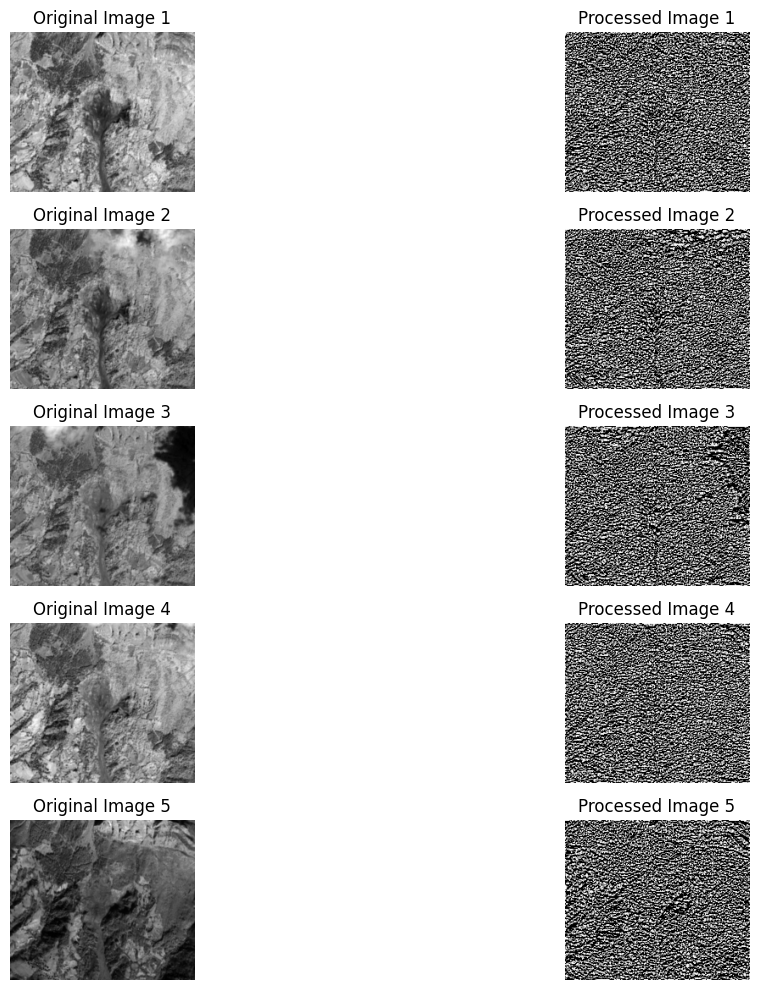

In [8]:
### PLOT ###

# Define the number of images to display
num_images = min(5, orig.shape[2])

# Create subplots
fig, axes = plt.subplots(num_images, 2, figsize=(15, 2 * num_images))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(orig[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Processed image
    axes[i, 1].imshow(preprocessed_stack[:, :, i], cmap='gray')
    axes[i, 1].set_title(f'Processed Image {i+1}')
    axes[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

### **Defining Date Pairs for Analysis**
This block selects **valid date pairs** from metadata based on a **user-defined time separation range** (`min_separation` & `max_separation`).  

- **User-Defined Time Constraints**:  
  - **Minimum separation (`min_separation`)**: Default `1 year` → Captures **faster changes**, but may increase noise.  
  - **Maximum separation (`max_separation`)**: Default `5 years` → Detects **slower movements**, but increases the chance of weak matches.   

💡 **User Tip:**  
- **Shorter separations** → **Better matches**, but may not capture slow processes.  
- **Longer separations** → **Detects gradual changes**, but can result in **weaker correlations**.  
🔹 Adjust `min_separation` and `max_separation` **based on your study's needs**.  


In [9]:
min_separation = 1 # in years
max_separation = 5 # in years

metadata_path = f"{output_dir}/Updated_Metadata.csv"

dat1, dat2, separation, datax = define_date_pairs(metadata_path, min_separation=min_separation, max_separation=max_separation)

Number of valid separations: 775


# **Feature Tracking**

### **Test on a Single Image Pair**
This block tests tracking parameters on one image pair (`img1`: band 1, `img2`: band 35) to fine-tune before full-scale processing. Time separation between images affects detectability.

---

## **Core Parameters**
- **Method:** `"block_matching"` (**recommended**), `"optical_flow"` (noisier)
- **Function:** `"fft_ncc"` (**recommended**), `"phase_cross_corr"`, `"mean_optical_flow"`
- **Subpixel:** `"parabolic"` (**fast & accurate**), `"quadratic"` (slower but precise)
- **Block Size / Overlap:**
  - Small → more detail, slower
  - Large → faster, less precision
  - High overlap (e.g. `0.9`) improves results but increases runtime

---

## **Filtering (Apply After Full Stack Processing)**
- **Magnitude filter:** Acceptable range (`0.1–5`)
- **Zero masking:** Excludes pre-masked areas
- **Deviation filter:** Removes statistical outliers
- **Angular coherence:** Keeps vectors within `≤50°`
- **PKR threshold (`1.3`):** Filters weak correlation peaks
- **SNR threshold (`3`):** Retains confident matches

---

## **Performance Tips**
- **Speed depends on** image size, block size, overlap, filters
- **Too slow?** → Increase block size, reduce overlap  
- **Too noisy?** → Raise SNR, enable angular coherence

---

## **Outputs**
- Displacement (`u`, `v`), feature points, `pkr`, `snr`, and processing time for one image pair.

⚙️ Use this to validate settings before scaling up.

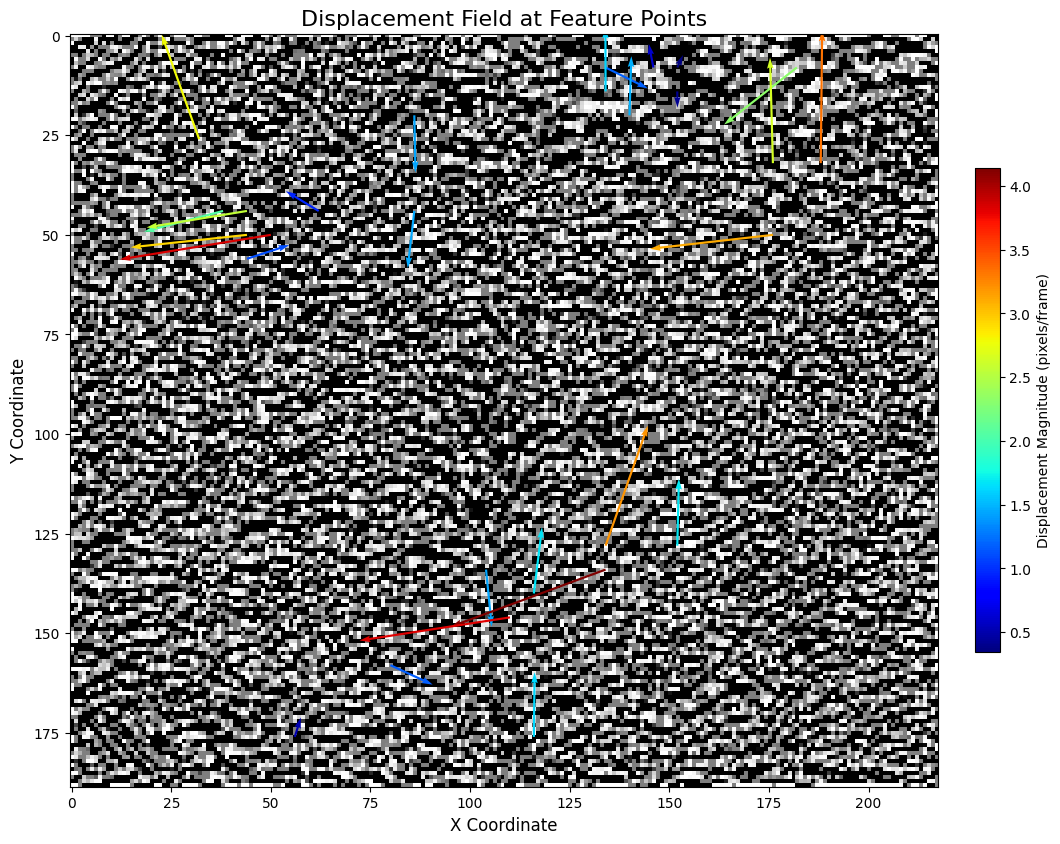

BLOCK MATCHING — Process completed in 0.49 seconds (1 pair).


In [10]:
import time

# --- Select Image Pair from Stack ---
# (Band indices: 0-based)
img1 = preprocessed_stack[:, :, 1]
img2 = preprocessed_stack[:, :, 40]

# --- Feature Tracking Parameters ---
method = 'block_matching'            # 'block_matching' or 'optical_flow'
match_func = 'fft_ncc'               # 'fft_ncc', 'phase_cross_corr', or 'mean_optical_flow'
subpixel_method = 'parabolic'        # 'center_of_mass', 'parabolic', 'quadratic'

block_size = 16
overlap = 0.6

# --- Displacement Limits ---
subpixel_precision = 0.1
max_displacement = block_size - 1

# --- Filtering Options ---
filter_params = {
    "apply_magnitude_filter": True,
    "min_magnitude": subpixel_precision,
    "max_magnitude": 5,

    "apply_zero_mask_filter": False,
    "apply_deviation_filter": False,
    "std_factor": 2.5,

    "apply_remove_median_displacement": True,
    "apply_median_filter_step": False,
    "filter_size": 5,

    "apply_angular_coherence_filter": False,
    "angular_threshold": 50,
    "smoothing_sigma": 1,

    "apply_erratic_displacement_filter": False,
    "neighborhood_size": 20,
    "deviation_threshold": 2.0,

    "apply_pkr_filter": False,
    "pkr_threshold": 1.3,

    "apply_snr_filter": False,
    "snr_threshold": 3,
}

# --- Run Displacement Analysis ---
start_time = time.time()

u, v, feature_points, pkr, snr = displacement_analysis(
    img1=img1,
    img2=img2,
    method=method,
    block_size=block_size,
    overlap=overlap,
    match_func=match_func,
    subpixel_method=subpixel_method,
    zero_mask=zero_mask,
    filter_params=filter_params,
    plot=True,
    arrow_scale=0.1
)

full_feature_points = feature_points  # Store full-resolution grid

# --- Timing ---
elapsed_time = time.time() - start_time
print(f"BLOCK MATCHING — Process completed in {elapsed_time:.2f} seconds (1 pair).")


In [11]:
# Estimate total processing time for all image pairs
num_pairs = len(separation)  # List of valid date pairs (from earlier step)
estimated_total_time = elapsed_time * num_pairs / 60  # in minutes

print(f"⏱️ Estimated total processing time for {num_pairs} pairs: {estimated_total_time:.1f} minutes (with parallel computing it'll be faster)")

⏱️ Estimated total processing time for 775 pairs: 6.3 minutes


### **Processing Image Pairs for Displacement Analysis**

This block runs **feature tracking** across multiple image pairs using the selected method.

---

## 🚨 Recommendation
**Disable all filters at this stage.**  
Apply filtering **after processing all pairs** to avoid inconsistent results. Early filtering may discard useful data — it's better to clean up with post-processing.

---

## 🛠 Output
- Displacement vectors (`u`, `v`)
- Feature points
- Quality metrics (`snr`, `pkr`, etc.)
- Prints `"FINALLY DONE!"` when complete — time for a caffè.

💡 **Tips**
- Adjust **block size** and **overlap** to manage speed vs. accuracy
- Apply filters like angular coherence or magnitude thresholds **afterward**

In [12]:
# FT parameters
method = 'block_matching' # block_matching, optical_flow
match_func = 'fft_ncc' # fft_ncc, phase_cross_corr, mean_optical_flow
subpixel_method='parabolic' # center_of_mass, quadratic, parabolic
block_size = 16
overlap = 0.6

# Compute minimum and maximum displacement
subpixel_precision = 0.1  # Typical subpixel precision for fft_ncc
max_displacement = block_size - 1  # Maximum displacement limited by block size

# Filter parameters must be all off here
filter_params = {
    "apply_magnitude_filter": False,
    "min_magnitude": subpixel_precision,  # Automatically set based on subpixel precision
    "max_magnitude": max_displacement,  # Maximum displacement limited by block size
    "apply_zero_mask_filter": False,
    "apply_deviation_filter": False,  # Enable filtering by deviation from mean
    "std_factor": 2.5,  # Allow deviation within n standard deviations
    "apply_remove_median_displacement": False,  # Remove the overall median displacement
    "apply_median_filter_step": False,  # Disable post-filtering with a median filter
    "filter_size": 5,  # Use a 5x5 median filter if enabled
    "apply_angular_coherence_filter": False,  # Enable angular coherence filtering
    "angular_threshold": 50,  # Angular threshold (degrees)
    "smoothing_sigma": 1,  # Smoothing parameter for angular coherence
    "apply_erratic_displacement_filter": False,  # Enable erratic displacement filtering
    "neighborhood_size": 20,  # Neighborhood size for erratic displacement filtering
    "deviation_threshold": 2.0,  # Threshold for deviation from neighborhood median
    'apply_pkr_filter': False,
    'pkr_threshold': 1.3,
    'apply_snr_filter': False,
    'snr_threshold': 3,
}

# Run the processing function
results = process_image_pairs(
    dat1=dat1,
    dat2=dat2,
    datax=datax,
    preprocessed_stack=preprocessed_stack,
    zero_mask=zero_mask,
    filter_params=filter_params,
    method=method,
    block_size=block_size,
    overlap=overlap,
    match_func=match_func,
    subpixel_method=subpixel_method,
    max_workers=12,
    parallel=True)

print('FINALLY DONE !')

Processing 775 image pairs...
Processed 10/775 pairs...
Processed 20/775 pairs...
Processed 30/775 pairs...
Processed 40/775 pairs...
Processed 50/775 pairs...
Processed 60/775 pairs...
Processed 70/775 pairs...
Processed 80/775 pairs...
Processed 90/775 pairs...
Processed 100/775 pairs...
Processed 110/775 pairs...
Processed 120/775 pairs...
Processed 130/775 pairs...
Processed 140/775 pairs...
Processed 150/775 pairs...
Processed 160/775 pairs...
Processed 170/775 pairs...
Processed 180/775 pairs...
Processed 190/775 pairs...
Processed 200/775 pairs...
Processed 210/775 pairs...
Processed 220/775 pairs...
Processed 230/775 pairs...
Processed 240/775 pairs...
Processed 250/775 pairs...
Processed 260/775 pairs...
Processed 270/775 pairs...
Processed 280/775 pairs...
Processed 290/775 pairs...
Processed 300/775 pairs...
Processed 310/775 pairs...
Processed 320/775 pairs...
Processed 330/775 pairs...
Processed 340/775 pairs...
Processed 350/775 pairs...
Processed 360/775 pairs...
Process

### **Saving Raw Feature Tracking (FT) Output**
This block **saves and loads** the raw **displacement results** from feature tracking.  

🚨 **Important:**  
- The function **does not overwrite existing files**.  
- If re-running this block, **manually delete the existing output** to avoid conflicts.  


In [13]:
data = handle_predictions(
    output_dir=output_dir,
    method=method,
    match_func=match_func,
    results=results,
    separation=separation,
    orig=orig,
    dat1=dat1,
    dat2=dat2,
    save=True,
    load=True
)

# Access variables
all_u = data['all_u']
all_v = data['all_v']
all_feature_points = data['all_feature_points']
all_pkrs = data['all_pkrs']
all_snrs = data['all_snrs']
separation = data['separation']
study_area_image = data['study_area_image']
dat1 = data['dat1']
dat2 = data['dat2']

File not found: outputs/outputs_displacement_results_block_matching_fft_ncc.npz. Switching to data creation from workspace.
Generating data from workspace variables...
Results saved in 'outputs' directory:
- Compressed NumPy file: outputs/outputs_displacement_results_block_matching_fft_ncc.npz


### **Pairwise Filtering**

Refines feature tracking results by removing unreliable displacement vectors using several techniques.

---

## **Filters Applied**
1. **Magnitude** — Removes values outside `0.1` to `block_size - 1`
2. **Zero Mask** — Excludes invalid pixels (e.g., clouds, water) *(off by default)*
3. **Deviation** — Removes outliers beyond `2.5σ`
4. **Median Shift** — Removes overall median displacement
5. **Angular Coherence** — Keeps vectors within `50°` of dominant direction
6. **Erratic Motion** — Removes local outliers (`20 px radius`, `2.0` threshold)
7. **PKR Threshold** — Filters weak matches (`> 1.5`)
8. **SNR Threshold** — Retains high-confidence points (`> 3`)

---

💡 **Tip**:  
Adjust `snr`, `pkr`, or `deviation` thresholds if results are too sparse.

🚀 Leaves only high-confidence vectors for post-analysis.

In [40]:
# Run this after the cells above to set an alert sound when the processing is finished
play_alert()

In [14]:
# --- Filtering Parameters ---
# These control which vectors are retained or removed post-tracking
filter_params = {
    "apply_magnitude_filter": True,          # Remove displacements below/above thresholds
    "min_magnitude": subpixel_precision,     # Minimum accepted motion
    "max_magnitude": max_displacement,       # Maximum accepted motion (usually block_size - 1)

    "apply_zero_mask_filter": False,         # Exclude pixels masked in any image (e.g., water/clouds)

    "apply_deviation_filter": False,         # Remove vectors far from statistical mean
    "std_factor": 2.5,                       # Standard deviation threshold for deviation filter

    "apply_remove_median_displacement": True,  # Subtract overall median motion (e.g., camera jitter)

    "apply_median_filter_step": False,       # Smooth vectors using a median filter
    "filter_size": 5,                        # Size of median filter kernel (if used)

    "apply_angular_coherence_filter": False, # Remove vectors that don’t align with dominant motion
    "angular_threshold": 50,                 # Max angular deviation (degrees)
    "smoothing_sigma": 1,                    # Angular coherence smoothing parameter

    "apply_erratic_displacement_filter": False,  # Remove isolated, noisy vectors
    "neighborhood_size": 20,                 # Radius for local filtering
    "deviation_threshold": 2.0,              # Threshold for local deviation

    "apply_pkr_filter": True,                # Remove low-quality matches using PKR
    "pkr_threshold": 1.3,                    # Minimum accepted peak-to-residual ratio

    "apply_snr_filter": True,                # Remove low-confidence vectors based on SNR
    "snr_threshold": 3,                      # Minimum signal-to-noise ratio
}

filtered_all_u = []
filtered_all_v = []
filtered_all_feature_points = []

for u, v, points, pkrs, snrs in zip(all_u, all_v, all_feature_points, all_pkrs, all_snrs):
    # Convert to numpy arrays with proper numeric types
    u = np.array(u, dtype=np.float64)
    v = np.array(v, dtype=np.float64)
    points = np.array(points, dtype=np.float64)
    pkrs = np.array(pkrs, dtype=np.float64)
    snrs = np.array(snrs, dtype=np.float64)

    # Optionally, align pkrs and snrs with u if there is a mismatch.
    if pkrs.shape[0] != u.shape[0]:
        print("Aligning pkr values: original shape", pkrs.shape, "expected:", u.shape)
        pkrs = pkrs[:len(u)]
    if snrs.shape[0] != u.shape[0]:
        print("Aligning snr values: original shape", snrs.shape, "expected:", u.shape)
        snrs = snrs[:len(u)]

    # Ensure zero_mask is an array if it exists (and has proper shape)
    if zero_mask is not None:
        zm = np.array(zero_mask)
    else:
        zm = None

    # Try to apply filtering
    try:
        u_filtered, v_filtered, points_filtered = filter_displacements(
            u, v, points, zm, pkr_values=pkrs, snr_values=snrs,
            **filter_params
        )
    except Exception as e:
        print("Error during filtering for one pair:")
        print("u:", u)
        print("v:", v)
        print("points:", points)
        print("pkrs:", pkrs)
        print("snrs:", snrs)
        raise e

    filtered_all_u.append(u_filtered)
    filtered_all_v.append(v_filtered)
    filtered_all_feature_points.append(points_filtered)

### **Median Displacement Computation**  
Aggregates filtered displacements across all image pairs, computes **median motion values** (displacement, magnitude, and direction), and visualizes the refined displacement field over the study area.  


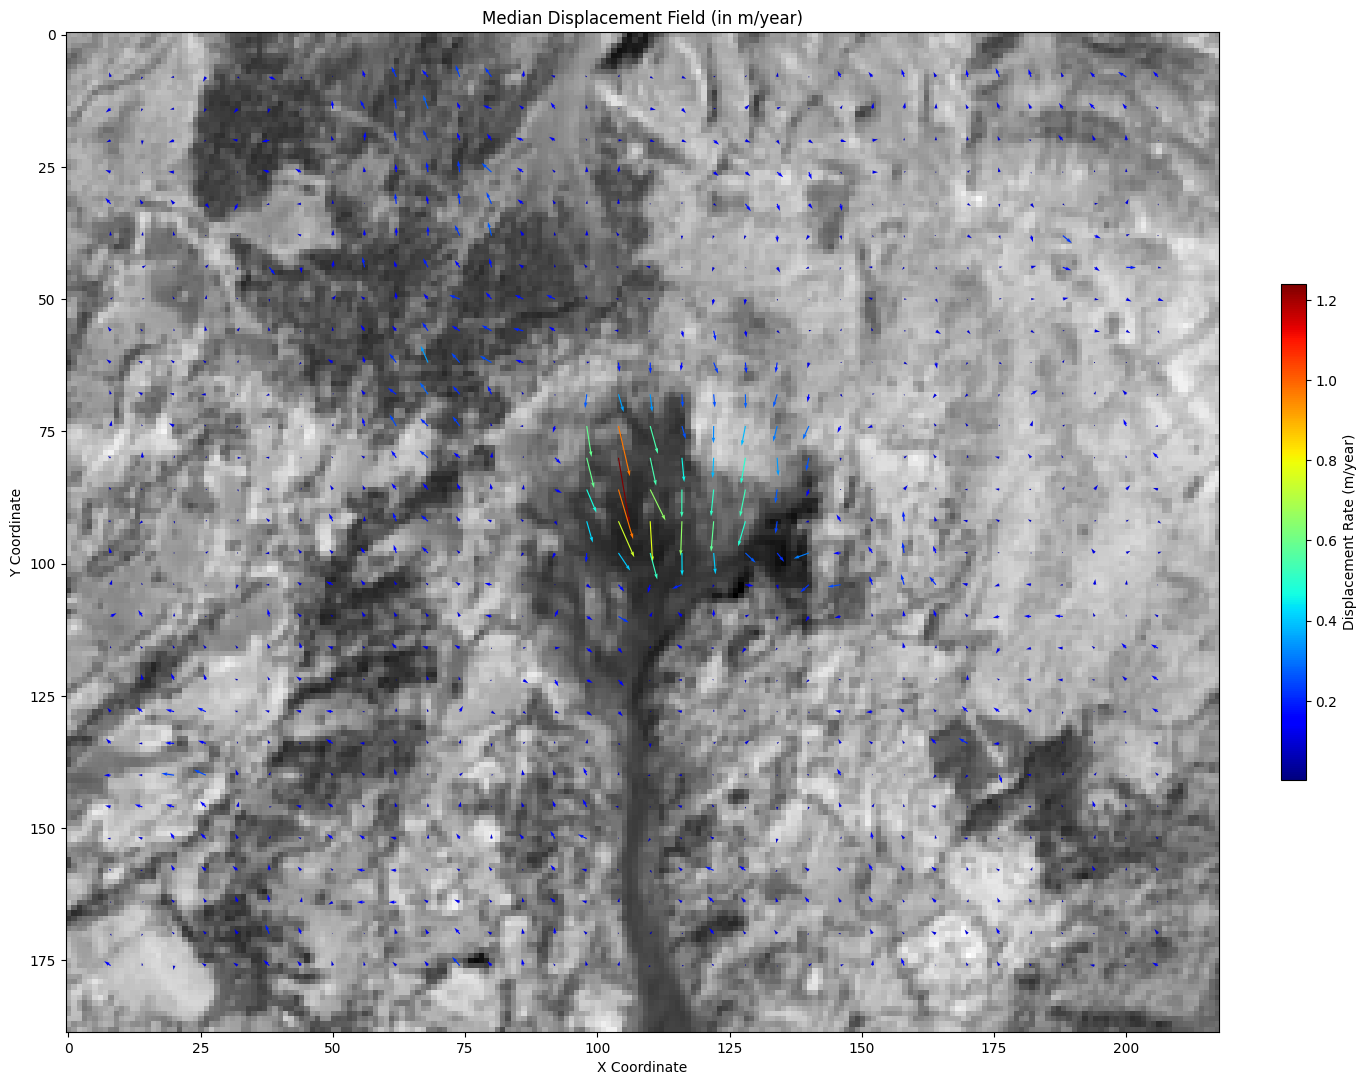

In [15]:
pixel_size = 10   # Pixel resolution in meters

# Step 1: Accumulate Displacements
displacement_data = accumulate_displacement(filtered_all_u, filtered_all_v, filtered_all_feature_points, separation)

# Step 2: Calculate Median Displacement
median_feature_points, median_u, median_v, median_magnitude, median_angles = calculate_median_displacement(displacement_data, pixel_size)

plot_displacement_field(median_feature_points, median_u, median_v, median_magnitude, study_area_image, arrow_scale=0.1)

### **Final Displacement Filtering & Visualization**  
Applies **terrain-based filters** (angular coherence, slope, aspect, clustering) to refine displacement data, removing weak or inconsistent movements. The DEM, slope, and aspect are resampled for accurate filtering, and the final **displacement field** is visualized.  



Using 95th Percentile of the Median Map as threshold: 0.24719711195250188
Plotting Median Displacement Field...


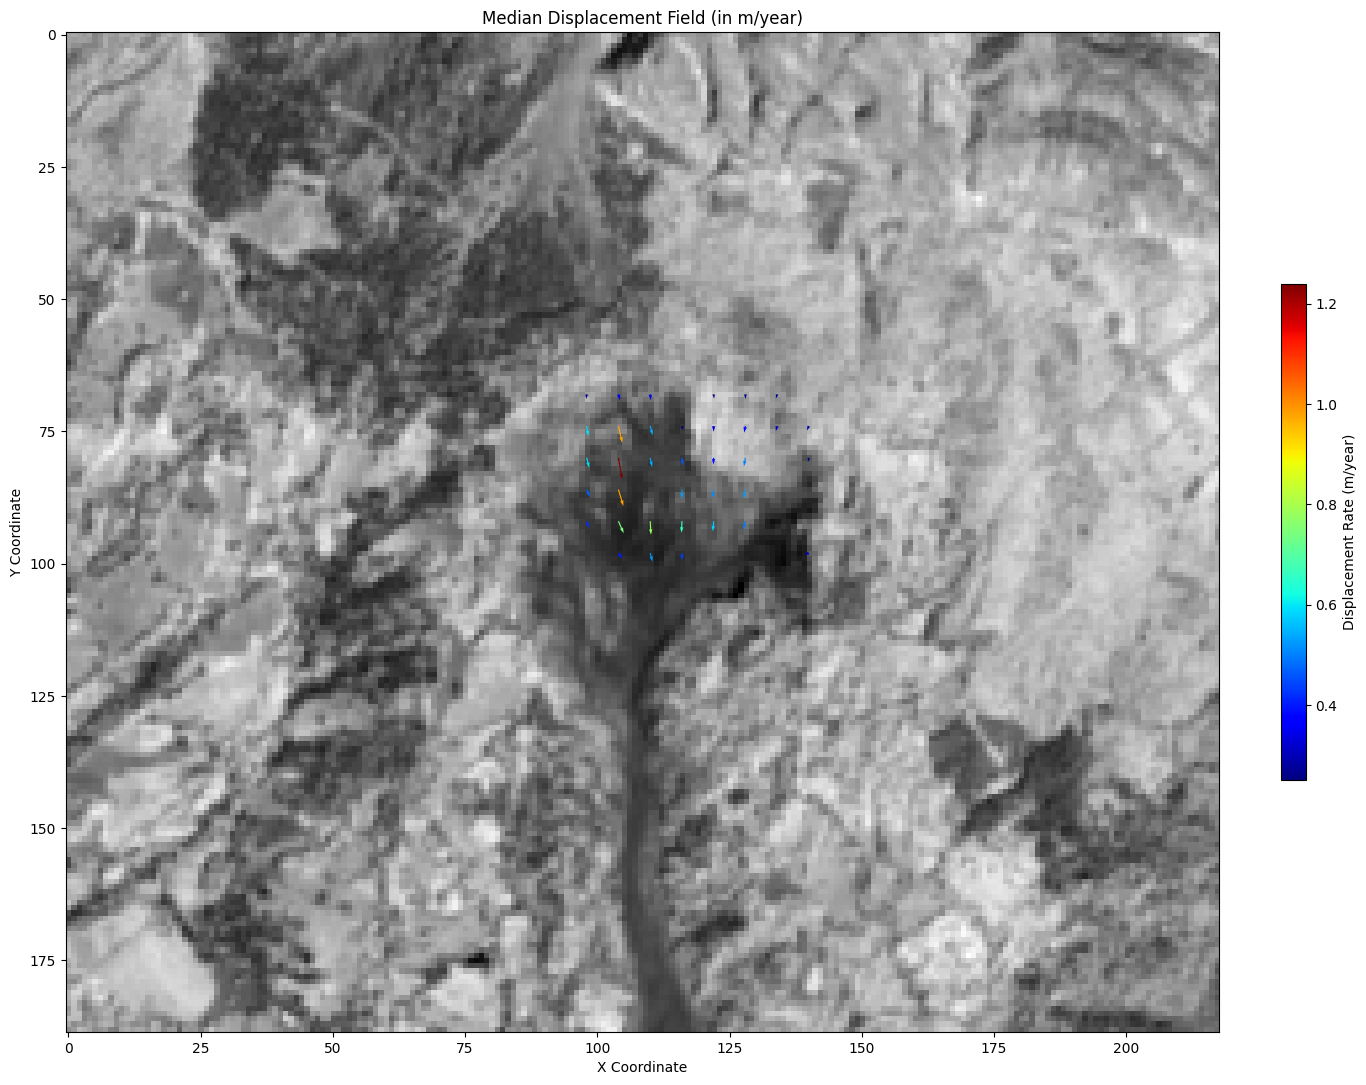

In [16]:
# Specify which filters to use & define parameters
manual_threshold=None                   # If None, 95th percentile is used

use_angular_coherence = True            # Use angular coherence filter
angular_threshold_degrees = 30          # Angular threshold in degrees
use_slope_filter = True                 # Skip slope filter
min_slope_threshold = 5                 # Minimum slope in degrees
use_aspect_filter = True                # Use aspect filter
aspect_tolerance = 30                   # Allowable deviation from downslope direction in degrees
use_clustering = True                   # Skip clustering filter
clustering_params = (20, 9)             # Clustering parameters: (eps, min_samples)

arrow_scale = 0.3                       # Scale of the vector arrow

# Resample morpho image to match `study_area_image` shape
morpho_path = f"{output_dir}/morpho.tif"
output_path = f"{output_dir}/resampled_morpho.tif"
resampled_morpho_path, resampled_transform = resample_morpho_to_match(study_area_image.shape, morpho_path, output_path)

# Open and plot the resampled DEM, slope, and aspect
with rasterio.open(resampled_morpho_path) as src:
    resampled_dem = src.read(1)  # Band 1: Resampled DEM
    resampled_slope = src.read(2)  # Band 2: Resampled slope
    resampled_aspect = src.read(3)  # Band 3: Resampled aspect

fil_median_feature_points, fil_median_u, fil_median_v, fil_median_magnitude = filter_final_map(
    median_feature_points, median_u, median_v, median_magnitude, median_angles,
    resampled_slope, resampled_aspect, study_area_image,
    angular_threshold_degrees=angular_threshold_degrees, min_slope_threshold=min_slope_threshold,
    aspect_tolerance=aspect_tolerance, smoothing_sigma=1, clustering_params=clustering_params,
    use_angular_coherence=use_angular_coherence, use_slope_filter=use_slope_filter,
    use_aspect_filter=use_aspect_filter, use_clustering=use_clustering, arrow_scale=arrow_scale,
    manual_threshold=manual_threshold
)

In [17]:
# From cartesian to raster

# filtered map
fil_u_map, fil_v_map, fil_magnitude_map, fil_angle_map = create_raster_maps(
    fil_median_feature_points, fil_median_u, fil_median_v, study_area_image, block_size, overlap
)

# full map
u_map, v_map, magnitude_map, angle_map = create_raster_maps(
    median_feature_points, median_u, median_v, study_area_image, block_size, overlap
)

### **Generating & Saving Motion Colormap**  
Creates a **refined displacement magnitude map**, overlays it on the composite image, and saves the result as `output_motion_colormap.tif` in GeoTIFF format, ensuring spatial alignment.  


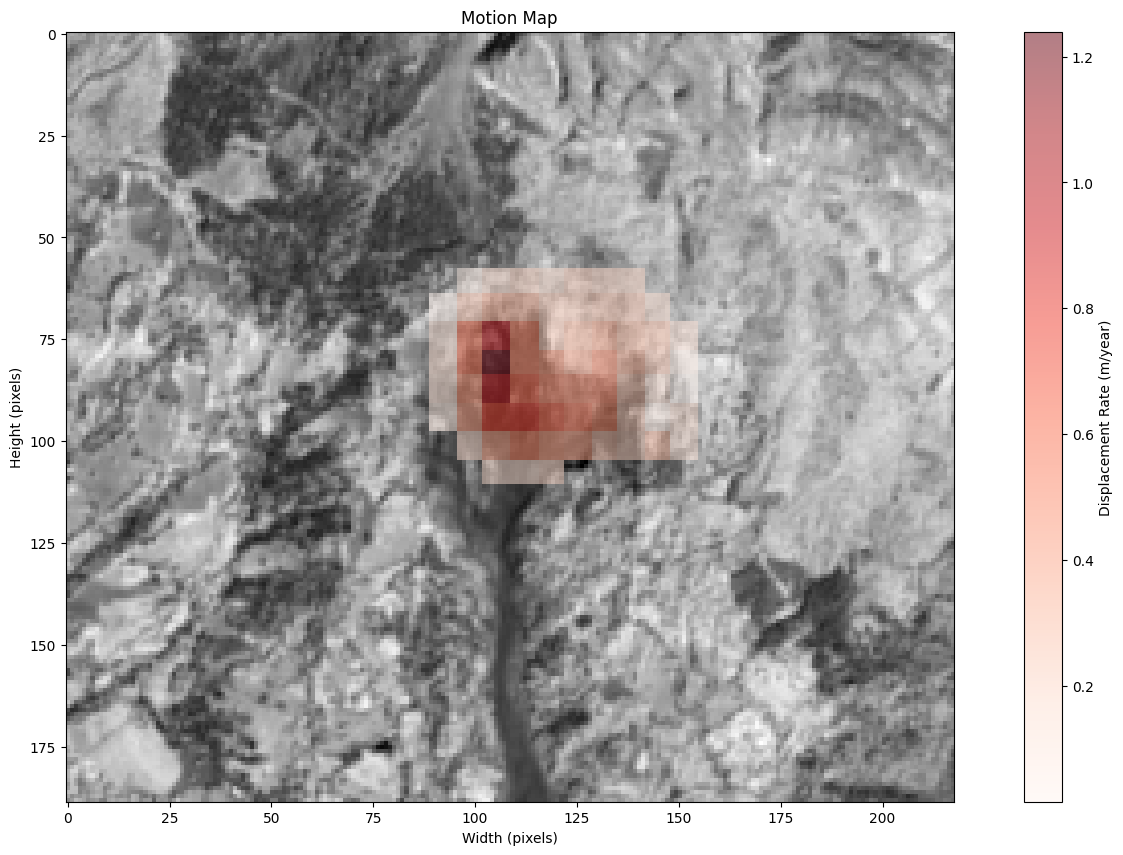

In [18]:
processed_mask = process_mask(fil_magnitude_map)

masked_magnitude = np.where(processed_mask, magnitude_map, np.nan)

orig_path = f'{output_dir}/S2_Composite_Filtered_8bit.tif'
output_path = f"{output_dir}/output_motion_colormap.tif"

# Generate the magnitude map
overlay_magnitude_map(orig[..., 0], masked_magnitude, block_size=block_size, overlap=overlap)

save_as_geotiff(orig_path, output_path, masked_magnitude, block_size, overlap)

### **Time Series Reconstruction & Velocity Estimation**

Reconstructs pixel-wise displacement time series and estimates average velocity from pairwise results.

- **Method**:  
  - `'weighted'` (**recommended**) — weights displacements by SNR/PKR confidence  
  - `'midpoint'` — bins displacements by image-pair mid-date (equal weight)

- **Temporal Resolution**:  
  - `months_per_bin=4` → Groups displacements into 4-month intervals  
  - Use smaller bins (e.g., `1`) for finer time resolution

- **Confidence Filtering**:  
  - `min_snr=3`, `min_pkr=1.3` — Filters out low-confidence displacements before time series reconstruction

🧠 **Tip**: Use `'weighted'` for better handling of irregular observation frequency and variable data quality.

In [19]:
displacement_data = accumulate_displacement_with_placeholders(
    filtered_all_u, filtered_all_v, filtered_all_feature_points, separation, fil_median_feature_points, dat1, dat2, pixel_size, all_pkrs, all_snrs
)

In [20]:
method = 'weighted' # 'weighted' or 'midpoint'
months_per_bin = 4
min_snr=3
min_pkr=1.3

velocity_estimates = estimate_velocity_time_series(displacement_data, method=method,
                                  months_per_bin=months_per_bin,min_snr=min_snr, min_pkr=min_pkr)

# Create velocity time series CSVs with median velocities for EW and SN components
csv_data_we, csv_data_ns, csv_data_mag = prepare_csv_with_components(velocity_estimates, geotiff_path=f'{output_dir}/S2_Composite_Filtered_8bit.tif')

# Save to CSV
csv_data_we.to_csv(f'{output_dir}/velocity_time_series_we.csv', index=False)
csv_data_ns.to_csv(f'{output_dir}/velocity_time_series_ns.csv', index=False)
csv_data_mag.to_csv(f'{output_dir}/velocity_time_series_mag.csv', index=False)

Using weighted method with quality filtering and daily aggregation.


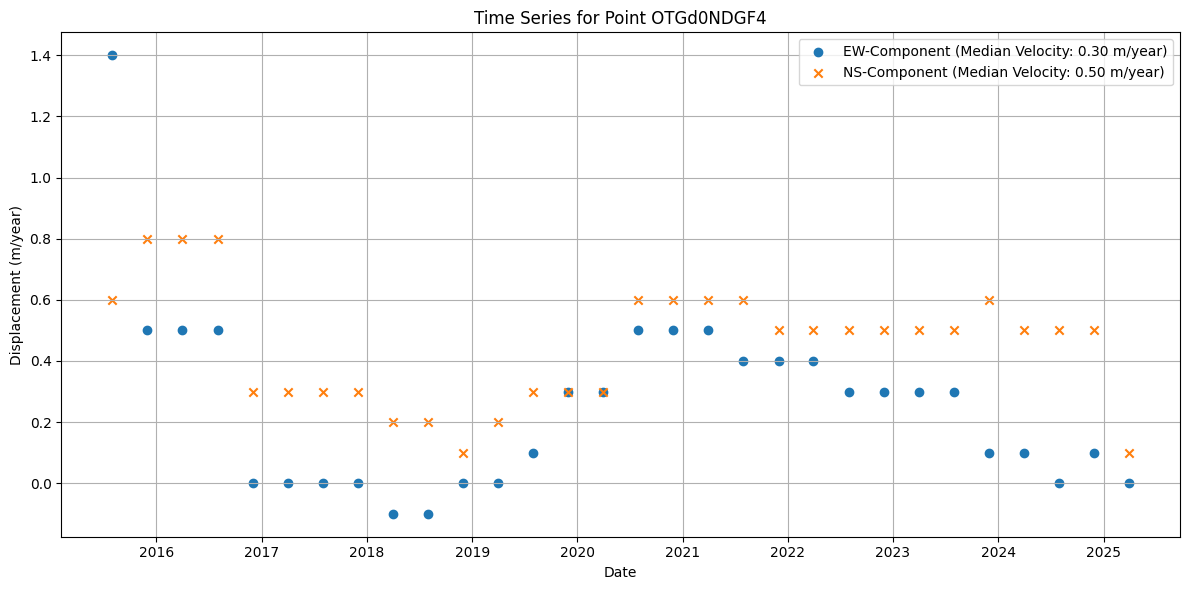

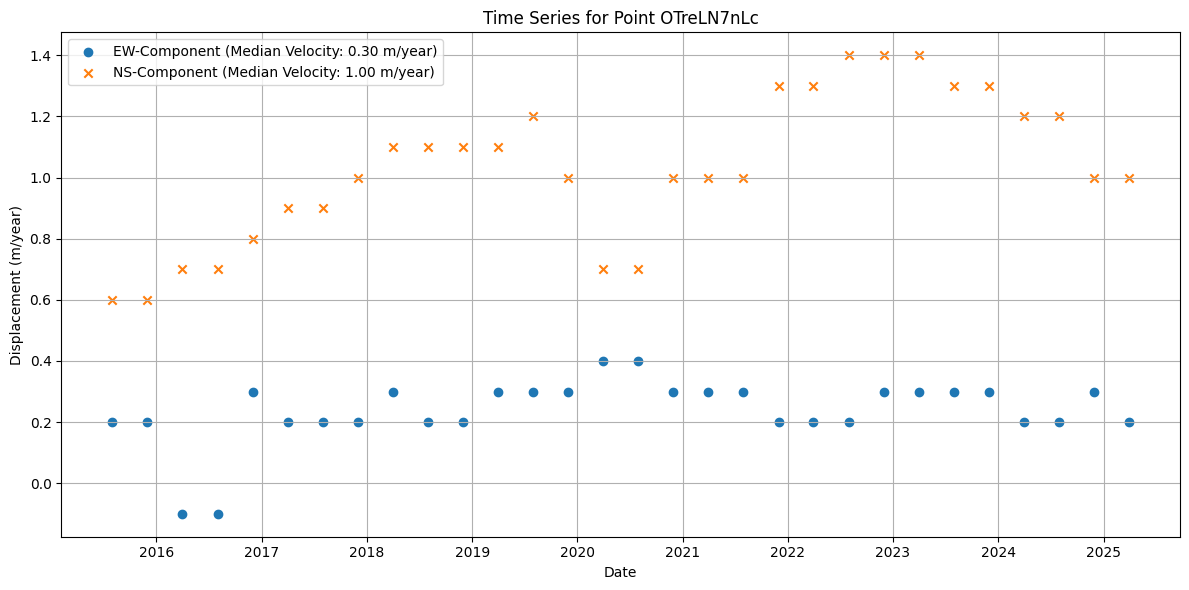

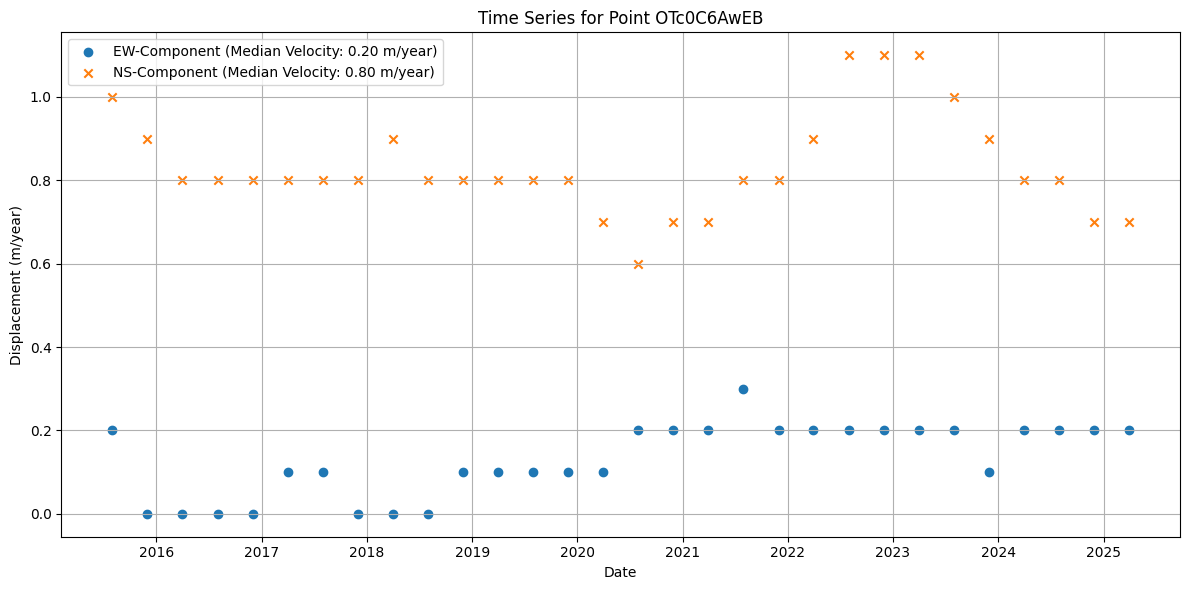

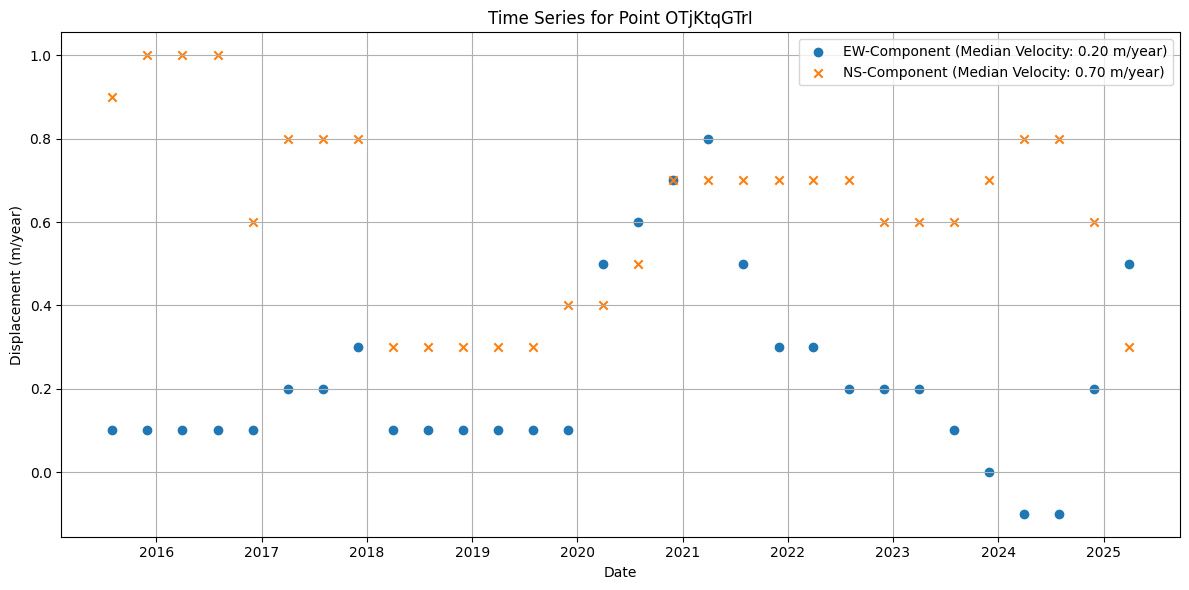

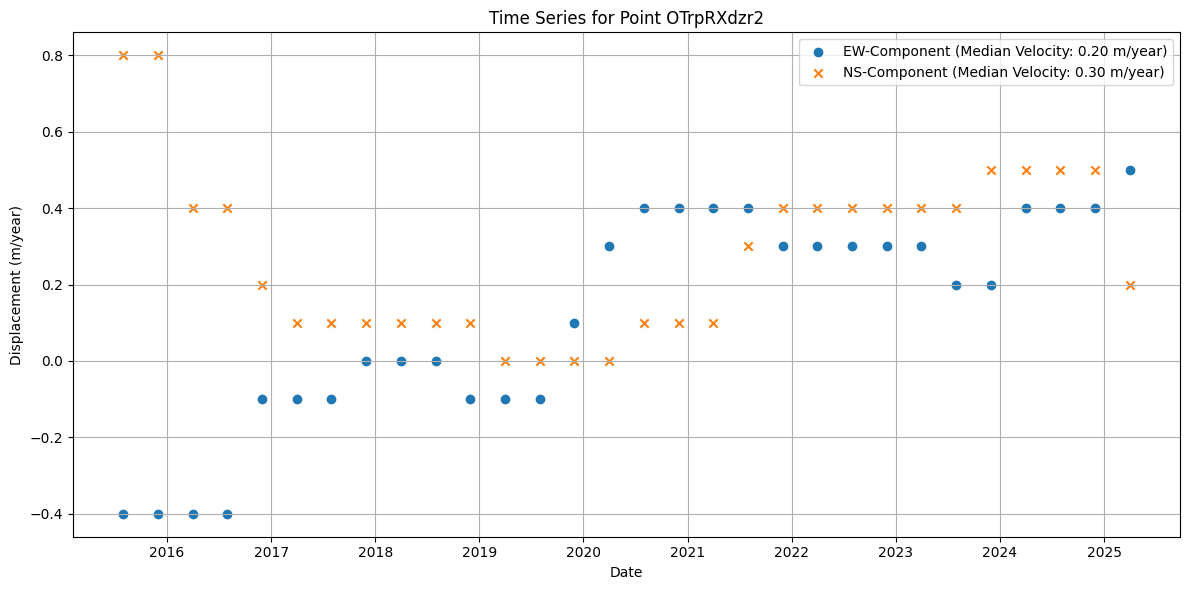

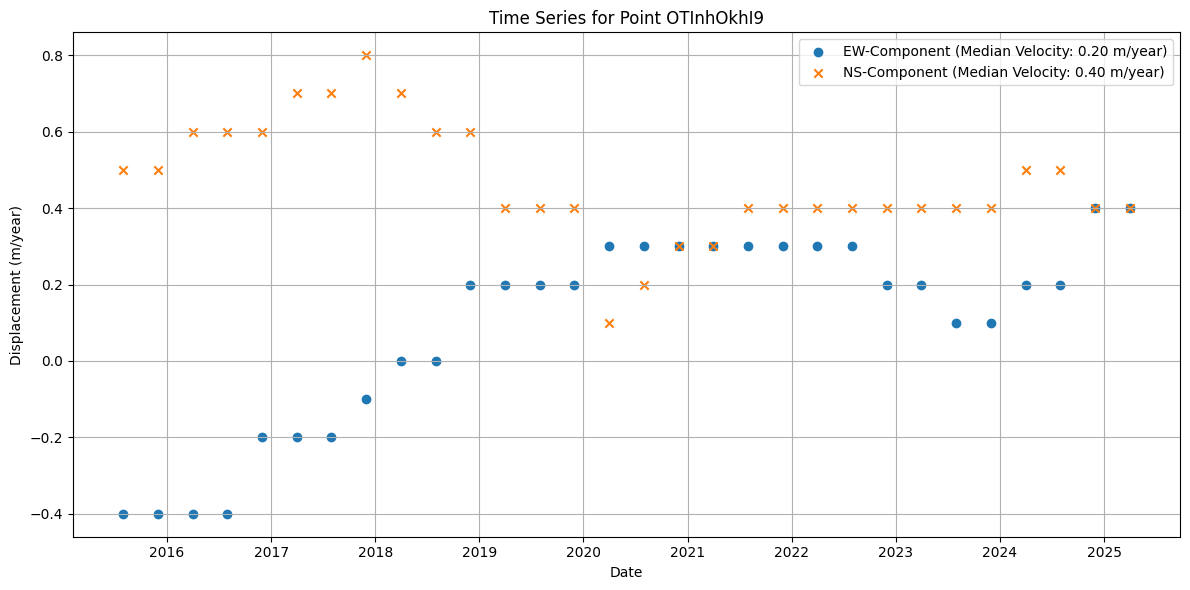

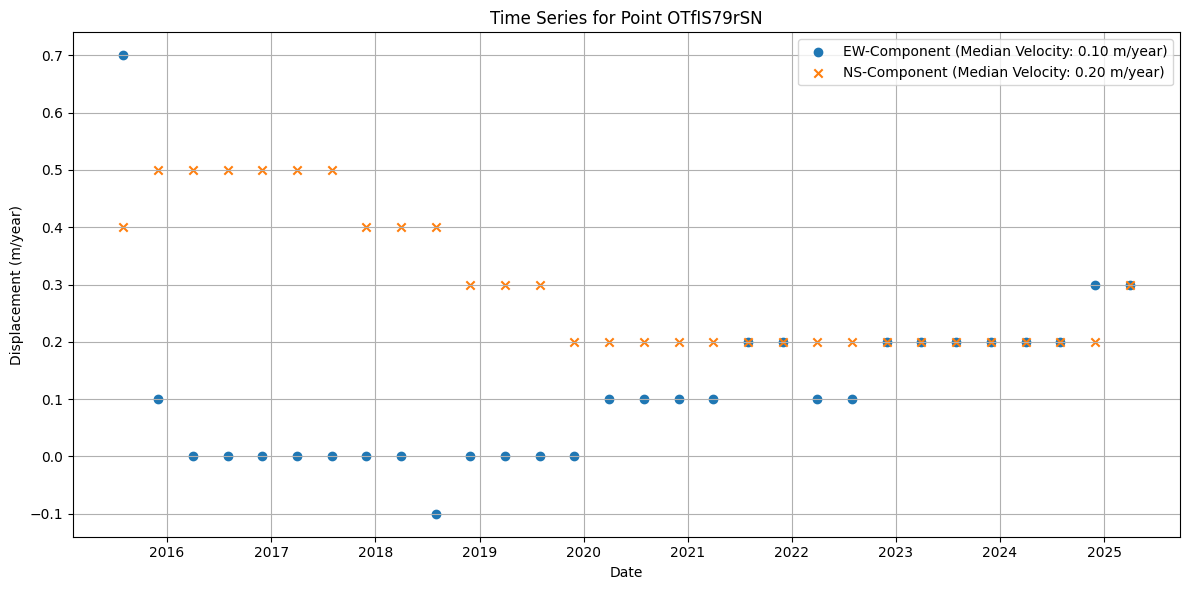

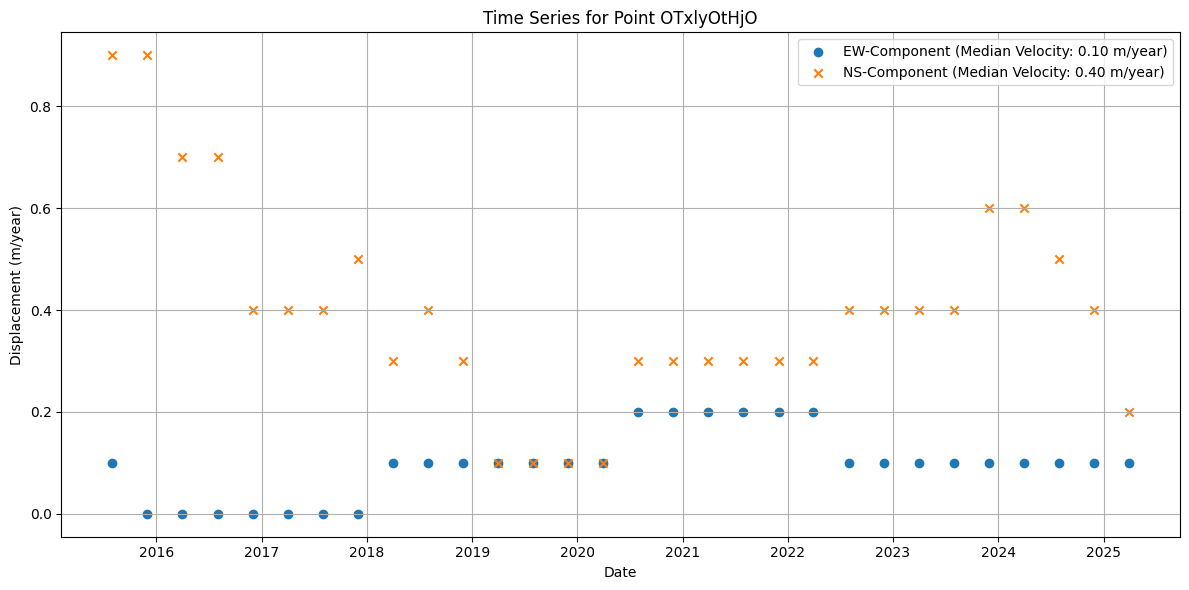

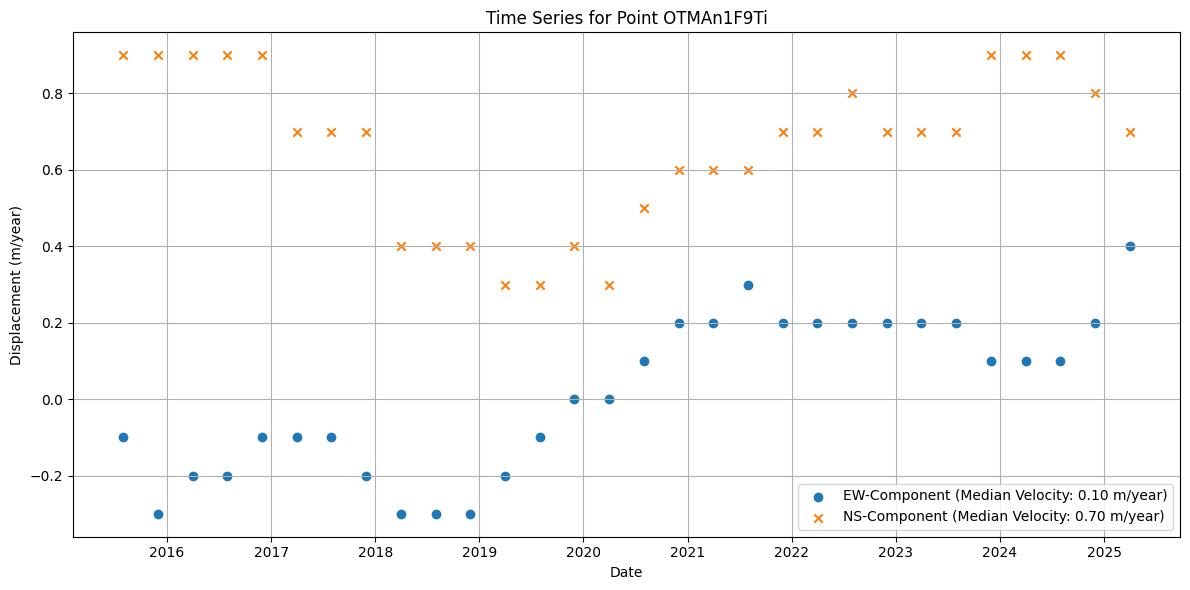

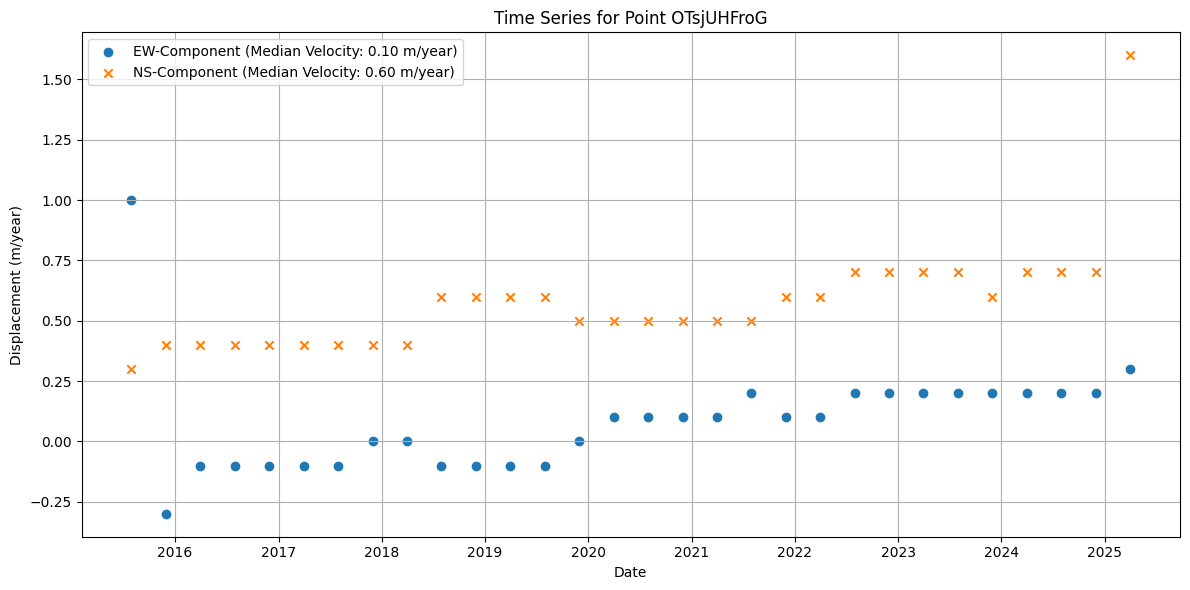

In [21]:
# Plot fastes points
plot_fastest_points_components(csv_data_we, csv_data_ns, top_n=2)

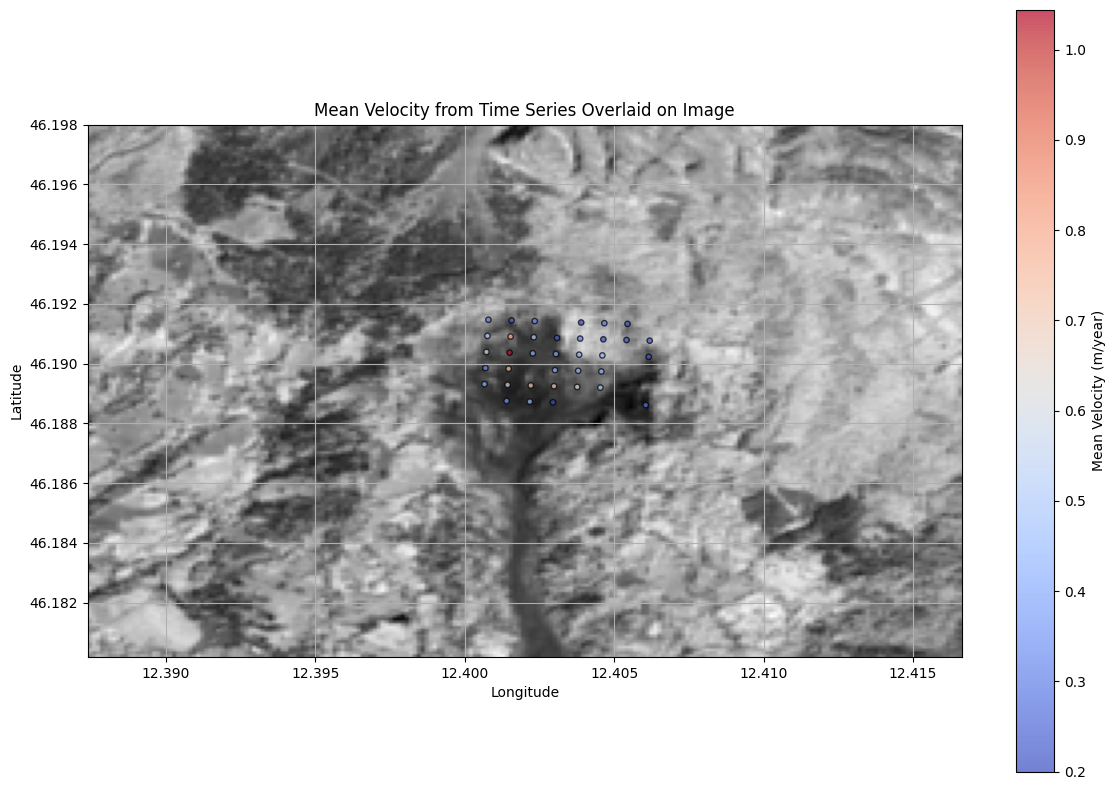

In [22]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
import pandas as pd

# Paths to input files
geotiff_path = f'{output_dir}/S2_Composite_Filtered_8bit.tif'
csv_ew_path = f'{output_dir}/velocity_time_series_we.csv'
csv_sn_path = f'{output_dir}/velocity_time_series_ns.csv'

# Load CSVs
csv_data_ew = pd.read_csv(csv_ew_path)
csv_data_sn = pd.read_csv(csv_sn_path)

# Combine WE and NS velocities into a single DataFrame
csv_data_ew['mean_velocity'] = (csv_data_ew['median_velocity']**2 + csv_data_sn['median_velocity']**2)**0.5

# Load GeoTIFF image and get transform & CRS
with rasterio.open(geotiff_path) as src:
    image = src.read(1)  # Read the first band
    transform = src.transform
    src_crs = src.crs

    # Get image bounds in the native CRS
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * image.shape[1]
    bottom = top + transform[4] * image.shape[0]

    # Transform bounds to EPSG:84 (WGS84) so they match the CSV lat/lon
    bounds_84 = transform_bounds(src_crs, 'EPSG:4326', left, bottom, right, top)

# bounds_84 is in the order (min_lon, min_lat, max_lon, max_lat)
xmin, ymin, xmax, ymax = bounds_84

# Plot the image using the transformed bounds
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='gray', extent=[xmin, xmax, ymin, ymax])
plt.title('Mean Velocity from Time Series Overlaid on Image')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay mean velocity as scatter points (CSV coordinates assumed to be in EPSG:84)
scatter = plt.scatter(
    csv_data_ew['longitude'], csv_data_ew['latitude'],
    c=csv_data_ew['mean_velocity'], cmap='coolwarm', s=15, edgecolor='k', alpha=0.7
)
plt.colorbar(scatter, label='Mean Velocity (m/year)')
plt.grid()
plt.tight_layout()
plt.show()

### ⬇️ Downloading Outputs

To download files directly from Colab to your computer. This creates a zip of the entire outputs folder and downloads it to device.


In [24]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive(f'Terratrack_Results_{output_dir}', 'zip', 'outputs')

# Download
files.download(f'Terratrack_Results_{output_dir}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inverse Velocity

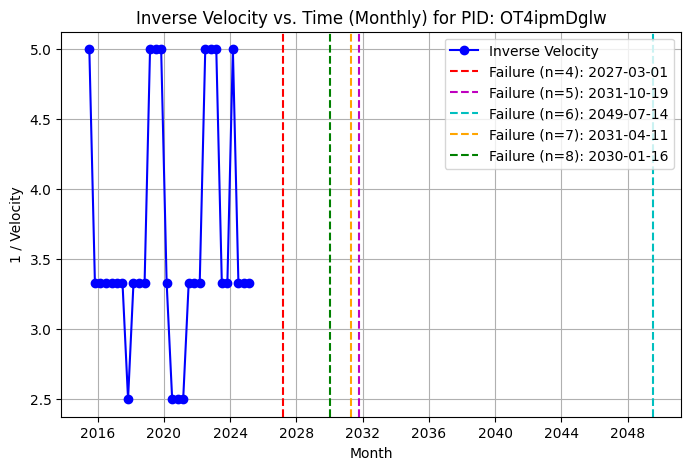

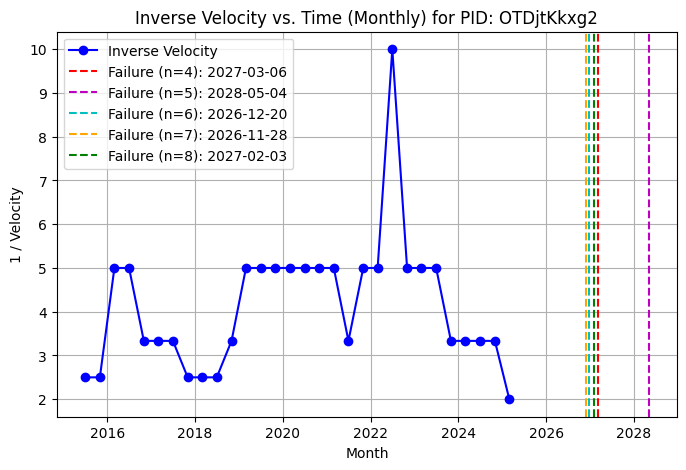

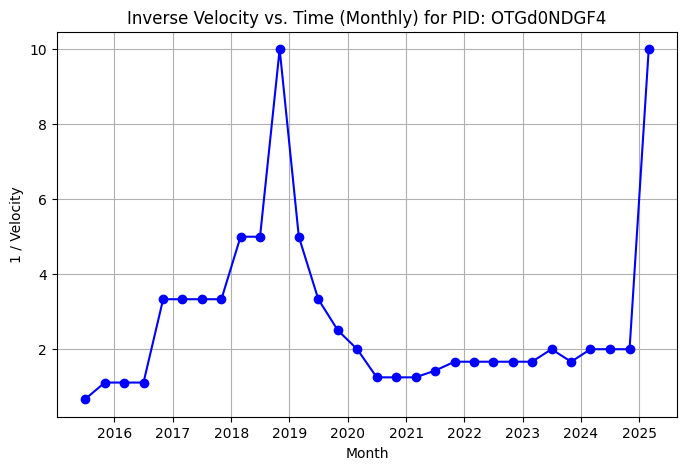

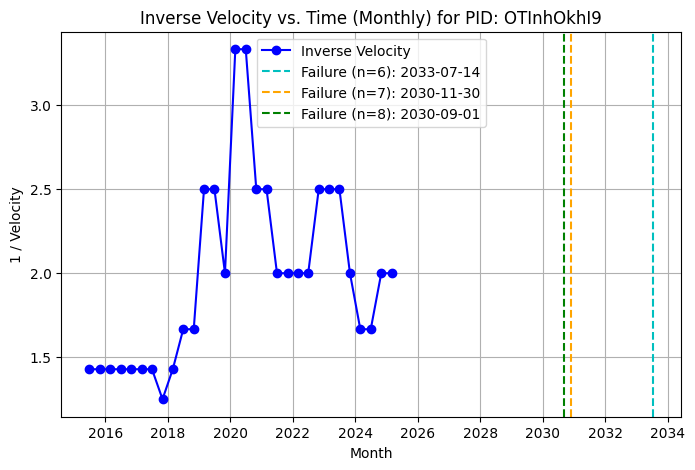

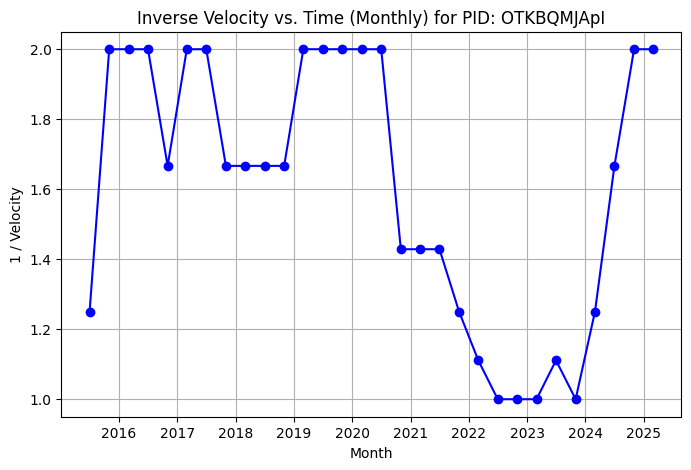

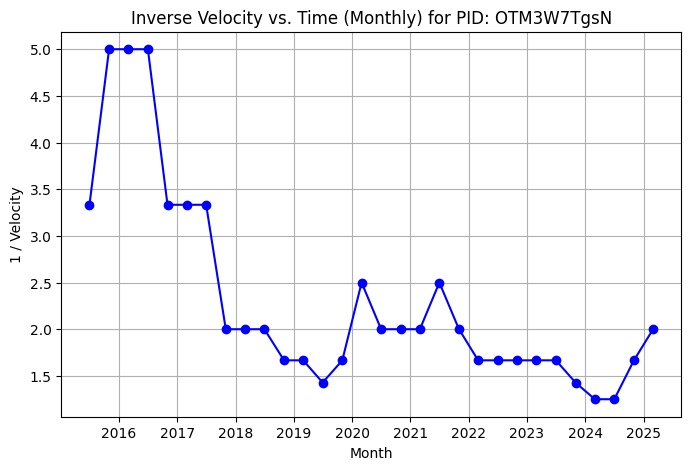

OutOfBoundsTimedelta: seconds=539513481600031326208, milliseconds=0, microseconds=0, nanoseconds=0

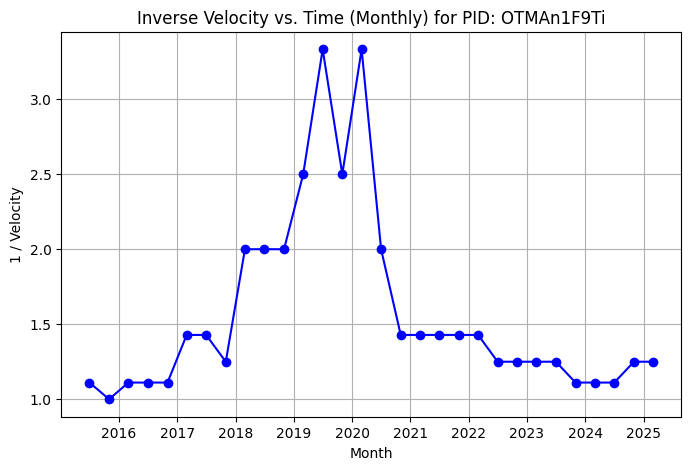

In [42]:
failure_dates_list = plot_inverse_velocity_monthly(f"{output_dir}/velocity_time_series_mag.csv", output_folder=f"{output_dir}/plots", save_plots=False, n_points_for_fit_list=[4,5,6,7,8])

In [ ]:
failure_counts = failure_date_statistics(failure_dates_list)
print(failure_counts)


In [ ]:
plot_failure_distribution(failure_counts)